# Using WPS through Jupyter Notebook

## Introduction
The Web Processing Service (WPS) allows you to analyse the data and plot the results for easy understanding. Many different types of analyses are possible. In this demonstration we use the GEOGLAM Fractional Cover Monthly data and calculate the mean value for each time position. The values for three bands (Band 1-3) will be plotted.

In [5]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 09/12/2019; Last Modified: 16/12/2019  #
##########################################################

from owslib.wcs import WebCoverageService
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from netCDF4 import Dataset
import warnings
warnings.filterwarnings('ignore')


### Specify the URL of GSKY server and the layer name.

In [6]:
# Specify the GSKY production URL here. The layer is hard coded below.
gsky_url = 'https://gsky.nci.org.au/ows/geoglam'
wcs = WebCoverageService(gsky_url, version='1.0.0')
layer = "modis_fract_cov_monthly"


### Available time positions in the database

In [7]:
# This block of code is for informational purpose only. It lets you see the available time positions.
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
t = n_times-1

# Uncomment the line below to see all time positions.
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])
print(wcs[layer].timepositions[t])

2020-01-01T00:00:00.000Z


### Specify the bounding box
The BBox determines the area on the map to be analysed. The WCS service will return one NetCDF file for each time position. 

You can either give the bounding box values as west,south,east and north coordinates or pick a value from a list of tiles that cover the whole of Australia.Click [here](http://cmi.ga.gov.au/sites/default/files/2017-12/DEA%20Tiles_1.pdf) to view the map of tiles.

Set **use_tiles=1** to get the BBox from a tile number given as **tiles = \[nn_-nn\]**. Otherwise, set it as 0 and type in the BBox

In [8]:
# The BBOX can either be specified as w,s,e,n or taken from a list of tiles. 
# Specify below as 1 or 0 to denote that the BBOX is to be taken as a tile or as actual values
use_tiles = 1

if use_tiles:
    tiles_list = {}
    with open("tiles_bboxes.txt") as f:
        for line in f:
            (key, val) = line.split()
            tiles_list[str(key)] = val

    # Uncomment below to see all tiles and ther BBoxes
    #print(tiles_list)

    # Give one tile below.
    tiles = ['17_-39']  # Sydney
    #tiles = ['15_-40']  # ACT
    bbox = [tiles_list[tiles[0]]]
else:
    # If you know a BBox containing data (Tip: use TerriaMap to find out) then type it in below.
    bbox = ['150.52,-34.15,151.34,-33.56'] # Sydney
bbox

['150.51,-33.56,151.75,-34.58']

### Retrieve the bands and calculate the means

The output from WCS service is converted into a **netCDF4.\_netCDF4.Dataset** in memory. The **Band1, Band2 and Band3** are **numpy.ma.core.MaskedArray** objects. Presumably, it means that the invalid data are already masked. Hence, taking a mean of the array may give the correct result (This must be confirmed!).

By default the entire set of time positions will be used in the analysis. It may take 3-5 minutes to complete depending on the number of time points. You can limit the time points to a specified number from the beginning. It is currently not possible to choose a range, but it can be added if necessary.

In [9]:
# Get the data for each time position
nd = len(wcs[layer].timepositions)

# Specify a number below to limit the time positions processed
#nd = 10

# These arrays keep the raw data as numpy.ma.core.MaskedArray 
orig_Band1 = []
orig_Band2 = []
orig_Band3 = []

# Get the NetCDF files via WCS
for t in range(nd-1):
    output = wcs.getCoverage(identifier=layer, Styles='',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

    # Store the NetCDF as diskless in memory. No writing to the disk even when the file is closed.
    nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
#     print(nc)
    # Get the band values
    band1 = nc.variables['Band1'][:] 
    band2 = nc.variables['Band2'][:] 
    band3 = nc.variables['Band3'][:] 
    
    # Calculate the mean values
    mean1 = band1.mean() # mean
    orig_Band1.append(mean1)
    mean2 = band2.mean() # mean
    orig_Band2.append(mean2)
    mean3 = band3.mean() # mean
    orig_Band3.append(mean3)
    print(".", end='')
print("")    
print("Mean1: {:0.4f}".format(mean1))
print("Mean2: {:0.4f}".format(mean2))
print("Mean3: {:0.4f}".format(mean3))

....................................................................................................................................................................................................................................
Mean1: 13.6732
Mean2: 44.0357
Mean3: 40.6399


### Plot the values

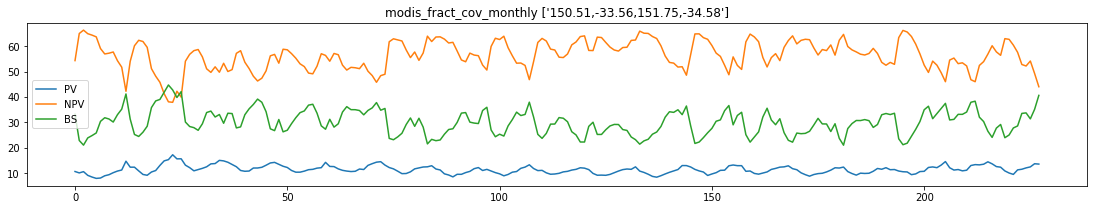

In [10]:
plt.figure(figsize=(19, 3))
Band1 = pd.DataFrame(orig_Band1)
Band2 = pd.DataFrame(orig_Band2)
Band3 = pd.DataFrame(orig_Band3)
ax = plt.subplot(111)
ax.plot(Band1, label='PV')
ax.plot(Band2, label='NPV')
ax.plot(Band3, label='BS')
title = layer + " " + str(bbox)
plt.title(title)
ax.legend()
plt.show()

## ______End of Notebook_______